# Test Delight Learn 

- author : Sylvie Dagoret-Campagne

- affiliation : IJCLab/IN2P3/CNRS
- creation date : March 17th 2021
- update : April 5th 2021

In [91]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

In [92]:
from matplotlib.colors import LogNorm

In [93]:
from mpi4py import MPI
from delight.photoz_kernels import Photoz_mean_function, Photoz_kernel

In [94]:
logger = logging.getLogger(__name__)
coloredlogs.install(level='DEBUG', logger=logger,fmt='%(asctime)s,%(msecs)03d %(programname)s, %(name)s[%(process)d] %(levelname)s %(message)s')

In [95]:
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

# Configuration

- select if want to control Delight internal simulation or DC2

In [96]:
FLAG_DC2=True

In [97]:
if FLAG_DC2:
    configfilename='tmp/parametersTest.cfg'
    flux_multiplicative_factor=1.
    flux_multiplicative_factor2=1.
    flux_multiplicative_factor=0.45e-10 # factor such if it multiplies data flux in sim gives true data flux
    flux_multiplicative_factor2=0.45e-4 # factor such if it is multiplied to models it gives true data flux level
else:
    configfilename='tmpsim/parametersTest.cfg'
    flux_multiplicative_factor=0.45e-10 # factor such if it multiplies data flux in sim gives true data flux
    flux_multiplicative_factor2=0.45e-4 # factor such if it is multiplied to models it gives true data flux level

# Load config and data

In [98]:
params = parseParamFile(configfilename, verbose=False)


comm = MPI.COMM_WORLD
threadNum = comm.Get_rank()
numThreads = comm.Get_size()


if threadNum == 0:
    logger.info("--- DELIGHT-LEARN ---")


2021-05-18 16:38:31,214 ipykernel_launcher.py, __main__[177] INFO --- DELIGHT-LEARN ---


In [99]:
# Read filter coefficients, compute normalization of filters
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms = readBandCoefficients(params)
numBands = bandCoefAmplitudes.shape[0]

redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)

f_mod = readSEDs(params)

In [100]:
all_renormmodel=[]
all_fluxes=[]

# Learn

In [101]:

numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))

msg= 'Number of Training Objects ' + str(numObjectsTraining)
logger.info(msg)


firstLine = int(threadNum * numObjectsTraining / numThreads)
lastLine = int(min(numObjectsTraining,(threadNum + 1) * numObjectsTraining / numThreads))
numLines = lastLine - firstLine

    
msg ='Thread ' +  str(threadNum) + ' , analyzes lines ' + str(firstLine) + ' , to ' + str(lastLine)
logger.info(msg)

DL = approx_DL()
gp = PhotozGP(f_mod, bandCoefAmplitudes, bandCoefPositions, bandCoefWidths,
              params['lines_pos'], params['lines_width'],
              params['V_C'], params['V_L'],
              params['alpha_C'], params['alpha_L'],
              redshiftGridGP, use_interpolators=True)

B = numBands
numCol = 3 + B + B*(B+1)//2 + B + f_mod.shape[0]
localData = np.zeros((numLines, numCol))
fmt = '%i ' + '%.12e ' * (localData.shape[1] - 1)

loc = - 1
crossValidate = params['training_crossValidate']
trainingDataIter1 = getDataFromFile(params, firstLine, lastLine,prefix="training_", getXY=True,CV=crossValidate)


all_bestType = []

if crossValidate:
    chi2sLocal = None
    bandIndicesCV, bandNamesCV, bandColumnsCV,bandVarColumnsCV, redshiftColumnCV = readColumnPositions(params, prefix="training_CV_", refFlux=False)

for z, normedRefFlux,\
    bands, fluxes, fluxesVar,\
    bandsCV, fluxesCV, fluxesVarCV,\
    X, Y, Yvar in trainingDataIter1:

    loc += 1
    
    
    if loc<0:
        print(loc," bands=",fluxes)
        print(loc," fluxes=",fluxes)
        print(loc," X=",X)
        print(loc," Y=",Y)
    

    themod = np.zeros((1, f_mod.shape[0], bands.size))
    for it in range(f_mod.shape[0]):
        for ib, band in enumerate(bands):
            themod[0, it, ib] = f_mod[it, band](z)
            
    

    # probably calibrate the luminosity parameter l compared to the model
    # This 
    chi2_grid, ellMLs = scalefree_flux_likelihood(fluxes,fluxesVar,themod,returnChi2=True)

    bestType = np.argmin(chi2_grid)
    all_bestType.append(bestType)
    
    ell = ellMLs[0, bestType]
    X[:, 2] = ell
    
    if loc<0:
        print(loc," themod*ell=",themod[0,bestType,:]*ell)
        
    all_renormmodel.append(themod[0,bestType,:]*ell)
    all_fluxes.append(fluxes)

    gp.setData(X, Y, Yvar, bestType)
    lB = bands.size
    localData[loc, 0] = lB
    localData[loc, 1] = z
    localData[loc, 2] = ell
    localData[loc, 3:3+lB] = bands
    localData[loc, 3+lB:3+f_mod.shape[0]+lB+lB*(lB+1)//2+lB] = gp.getCore()
    
    


<ipython-input-101-8eed5ea63f22>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))
2021-05-18 16:38:31,461 ipykernel_launcher.py, __main__[177] INFO Number of Training Objects 3755
2021-05-18 16:38:31,462 ipykernel_launcher.py, __main__[177] INFO Thread 0 , analyzes lines 0 , to 3755


In [102]:
all_renormmodel=np.array(all_renormmodel)
all_fluxes=np.array(all_fluxes)

In [103]:
all_renormmodel.shape

(3755, 6)

In [104]:
all_fluxes.shape

(3755, 6)

# Plot

In [105]:
N=loc+1
N

3755

Text(0.5, 1.0, 'distribution of $z$')

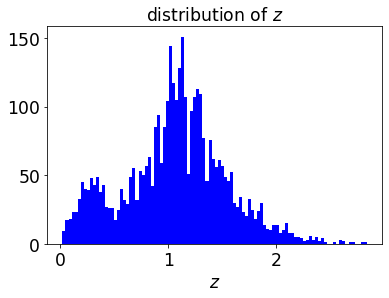

In [106]:
plt.hist(localData[:,1],bins=100,facecolor="b");
plt.xlabel("$z$")
plt.title("distribution of $z$")

Text(0.5, 1.0, 'distribution of fitted $\\ell$')

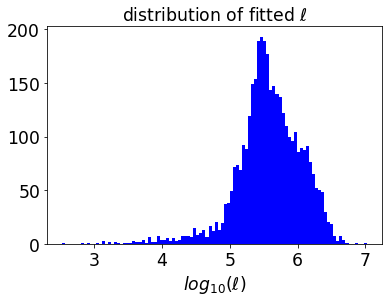

In [107]:
plt.hist(np.log10(localData[:,2]),bins=100,facecolor="b");
plt.xlabel("$log_{10}(\ell)$")
plt.title("distribution of fitted $\ell$")

Text(0.5, 1.0, '$\\ell$ vs $z$')

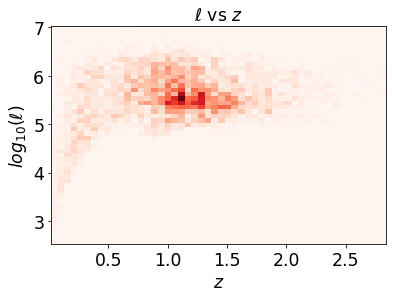

In [108]:
plt.hist2d(localData[:, 1],np.log10(localData[:,2]),(50,50),cmap="Reds");
plt.ylabel("$log_{10}(\ell)$")
plt.xlabel("$z$")
plt.title("$\ell$ vs $z$")

Text(0.5, 1.0, 'distribution of fitted type')

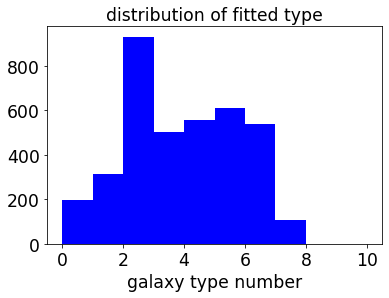

In [109]:
plt.hist(np.array(all_bestType),bins=10,range=(0,10),color="b",facecolor="b");
#plt.yscale('log')
plt.xlabel('galaxy type number')
plt.title("distribution of fitted type")

Text(0.5, 1.0, 'galaxy type versus redshift')

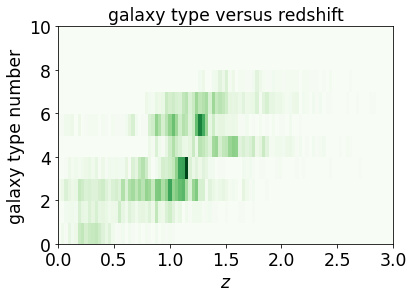

In [110]:
plt.hist2d(localData[:, 1],all_bestType,(100,10),range=((0,3),(0,10)),cmap="Greens");
plt.xlabel('$z$')
plt.ylabel('galaxy type number')
plt.title("galaxy type versus redshift")

In [111]:
# use MPI to get the totals
comm.Barrier()
if threadNum == 0:
    reducedData = np.zeros((numObjectsTraining, numCol))
else:
    reducedData = None



firstLines = [int(k*numObjectsTraining/numThreads) for k in range(numThreads)]
lastLines = [int(min(numObjectsTraining, (k+1)*numObjectsTraining/numThreads)) for k in range(numThreads)]
sendcounts = tuple([(lastLines[k] - firstLines[k]) * numCol for k in range(numThreads)])
displacements = tuple([firstLines[k] * numCol for k in range(numThreads)])

comm.Gatherv(localData, [reducedData, sendcounts, displacements, MPI.DOUBLE])
comm.Barrier()


In [112]:
reducedData.shape

(3755, 44)

In [113]:
#localData[:, 4]

In [114]:
band_name=["u","g","r","i","z","y"]

In [115]:
B

6

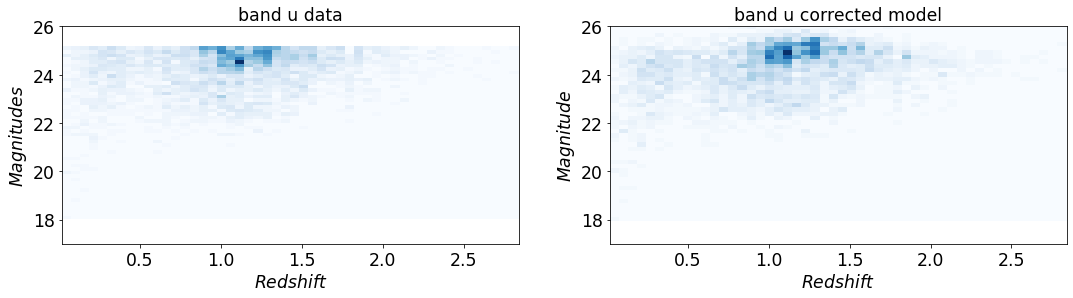

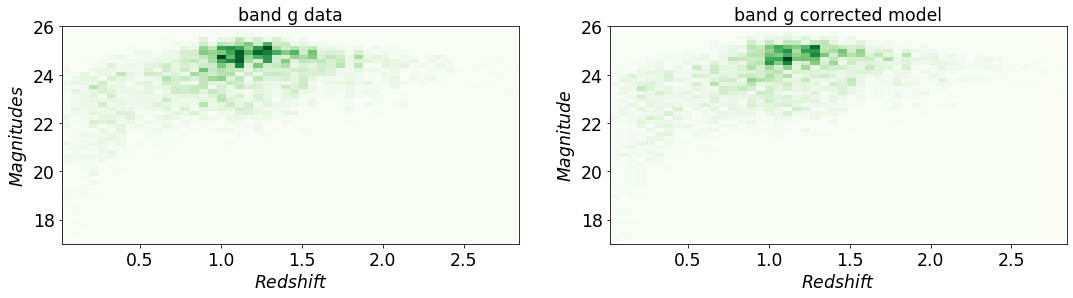

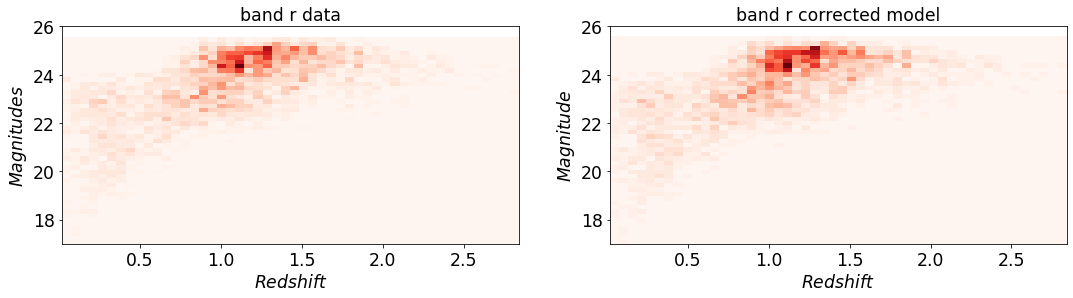

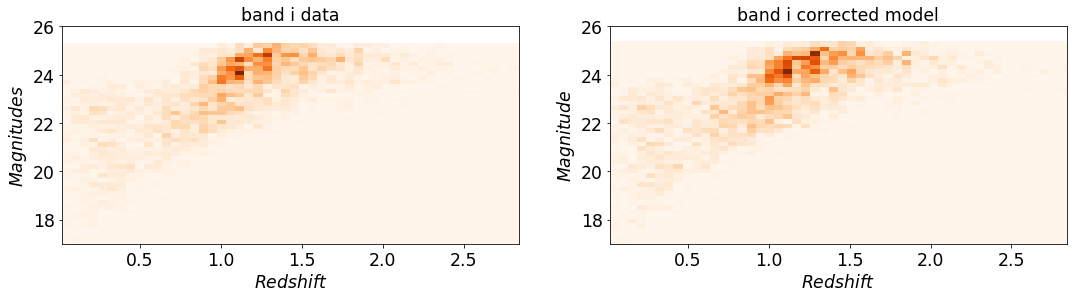

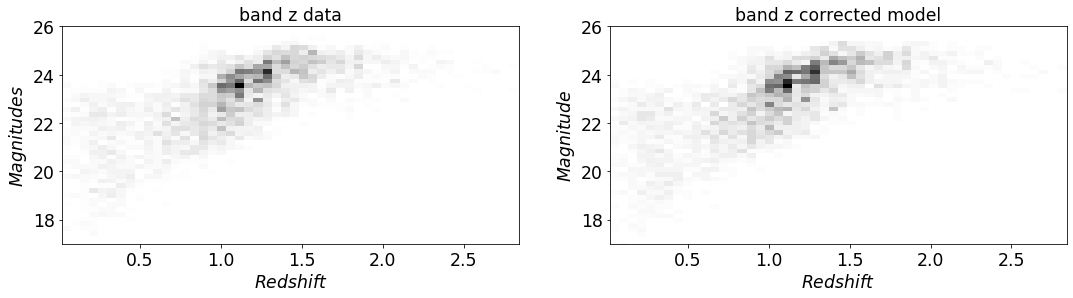

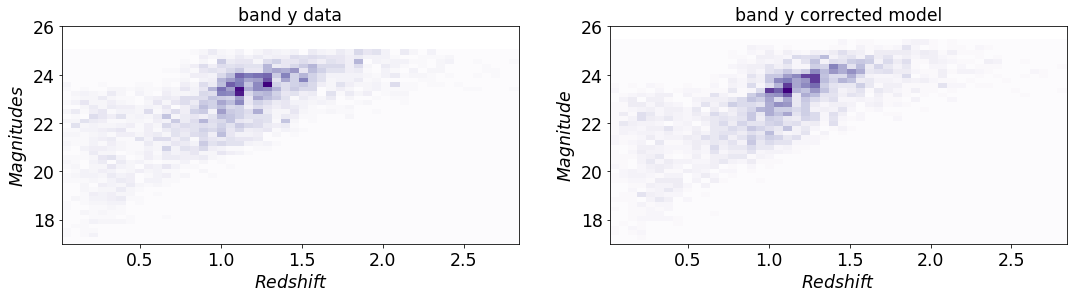

In [120]:
the_coloredmaps=["Blues","Greens","Reds","Oranges","Greys","Purples"]

for iband in np.arange(B):
    fig=plt.figure(figsize=(18,4))
    ax=fig.add_subplot(121)
    ymin=np.log10(all_fluxes[:,iband]).min()
    ymax=np.log10(all_fluxes[:,iband]).max()
    ax.hist2d(localData[:, 1],-2.5*np.log10(all_fluxes[:,iband]* flux_multiplicative_factor),(50,50),cmap=the_coloredmaps[iband]);
    title="band "+band_name[iband]+" data"
    ax.set_title(title)
    ax.set_xlabel("$Redshift$")
    ax.set_ylabel("$Magnitudes$")
    ax.set_ylim(17,26)
    ax=fig.add_subplot(122)
    ax.hist2d(localData[:, 1],-2.5*np.log10(all_renormmodel[:,iband]* flux_multiplicative_factor),(50,50),cmap=the_coloredmaps[iband]);
    ax.set_ylim(17,26)
    ax.set_xlabel("$Redshift$")
    ax.set_ylabel("$Magnitude$")
    title="band "+band_name[iband]+" corrected model"
    ax.set_title(title)
    plt.show()